In [1]:
import pandas as pd
import numpy as np
import urllib.request, urllib.error, urllib.parse
from datetime import timedelta
from keras.models import Sequential
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import Lasso
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Obtain data
Upper air (raob) and surface (metar) meteorological data scraped from archive maintained by Iowa State. Scraping code is given below as markdown. Data will be loaded as csv next.

raob data

`url='http://mesonet.agron.iastate.edu/cgi-bin/request/raob.py?station=KGSO&sts=01%2F01%2F1990+00%3A00&ets=03%2F01%2F2020+00%3A00&dl=on'
response = urllib.request.urlopen(url)
df_gso_raob=pd.read_csv(url, low_memory=False)`

metar data

`url='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=KGSO&data=tmpf&data=skyc1&data=mslp&year1=1990&month1=1&day1=1&year2=2020&month2=3&day2=1&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=yes&report_type=1&report_type=2'
response = urllib.request.urlopen(url)
df_gso_metar=pd.read_csv(url, low_memory=False)`

#### Load csv file

In [2]:
df_gso_raob=pd.read_csv("gso_raob_data.csv")
df_gso_metar=pd.read_csv("gso_metar_data.csv")

### Data Validation and Cleaning

In [3]:
#check raob dataframe contents
df_gso_raob.head()

,station,validUTC,levelcode,pressure_mb,height_m,tmpc,dwpc,drct,speed_kts,bearing,range_sm
0,KGSO,1990-01-15 12:00:00,NaN,994.0,277.0,6.1,-4.6,240.0,10.0,NaN,NaN
1,KGSO,1990-01-15 12:00:00,NaN,1000.0,227.0,NaN,NaN,NaN,NaN,NaN,NaN
2,KGSO,1990-01-15 12:00:00,NaN,990.0,306.0,6.2,-8.1,239.0,12.0,NaN,NaN
3,KGSO,1990-01-15 12:00:00,NaN,962.0,542.0,5.2,-8.6,237.0,35.0,NaN,NaN
4,KGSO,1990-01-15 12:00:00,NaN,954.0,609.0,NaN,NaN,235.0,37.0,NaN,NaN


In [4]:
#check raob dataframe contents
df_gso_metar.head()

,station,valid,tmpf,skyc1,mslp
0,GSO,1990-01-01 00:00,60.08,OVC,1005.50
1,GSO,1990-01-01 01:00,60.08,SCT,1005.50
2,GSO,1990-01-01 02:00,60.98,BKN,1005.10
3,GSO,1990-01-01 03:00,60.08,BKN,1004.70
4,GSO,1990-01-01 03:07,M,BKN,M


#### Replace missing 'M' values with NaN and convert variables to appropriate types.

In [5]:
#replace missing 'M' values with nan
df_gso_raob.replace('M', np.nan, inplace=True)
df_gso_metar.replace('M', np.nan, inplace=True)

#convert valid to datetime
df_gso_metar['valid']=df_gso_metar['valid'].astype('datetime64')
df_gso_raob['validUTC']=df_gso_raob['validUTC'].astype('datetime64')

#convert continuous numerical columns to be used to float
df_gso_metar[['tmpf', 'mslp']]=df_gso_metar[['tmpf', 'mslp']].astype('float')
df_gso_raob[['pressure_mb', 'height_m']]=df_gso_raob[['pressure_mb', 'height_m']].astype('float')

#### Check data values by using describe.

In [6]:
df_gso_raob.describe()

,levelcode,pressure_mb,height_m,tmpc,dwpc,drct,speed_kts,bearing,range_sm
count,297470.000000,320599.000000,320542.000000,201039.000000,200636.000000,217367.000000,217322.000000,196493.000000,196493.000000
mean,5.384136,914.400697,998.993957,11.119025,2.735708,209.916404,15.327891,126.849216,0.340139
std,1.214564,253.898267,812.439235,8.611892,12.337166,98.982603,10.284562,99.317416,5.579328
min,4.000000,800.100000,-212.000000,-24.300000,-61.100000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,850.000000,498.000000,5.000000,-5.000000,150.000000,8.000000,45.000000,0.000000
50%,5.000000,912.500000,914.000000,11.600000,5.000000,233.000000,13.000000,109.000000,0.000000
75%,6.000000,961.000000,1503.000000,17.500000,12.300000,285.000000,21.000000,206.000000,0.000000
max,9.000000,9999.900000,65530.000000,37.000000,28.200000,360.000000,308.000000,359.000000,783.000000


In [7]:
df_gso_metar.describe()

,tmpf,mslp
count,285514.000000,265243.000000
mean,59.060654,1017.914685
std,16.614410,6.630732
min,-0.940000,970.000000
25%,46.040000,1013.800000
50%,60.980000,1017.800000
75%,71.960000,1022.100000
max,100.940000,1046.100000


#### Check distributions of data and range of values

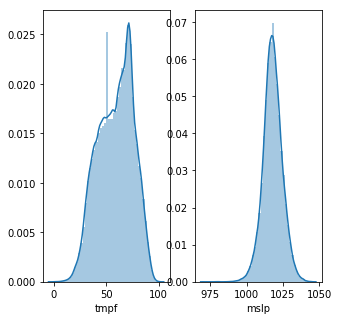

In [8]:
#check values of metar data
f, axes = plt.subplots(1,2 , figsize=(5,5))
sns.distplot( df_gso_metar['tmpf'].dropna(), ax=axes[0])
sns.distplot( df_gso_metar['mslp'].dropna(), ax=axes[1])

#values look reasonable and relatively normally distributed

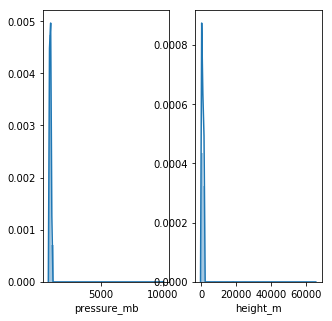

In [9]:
#check values of raob data
f, axes = plt.subplots(1,2 , figsize=(5,5))
sns.distplot(df_gso_raob['pressure_mb'].dropna(), ax=axes[0])
sns.distplot(df_gso_raob['height_m'].dropna(), ax=axes[1])

#### Large values showing in both pressure and height - 9999.9 also denotes missing values. Set these values to NaN.

In [10]:
#set pressure greater than 1050 mb to np.nan
df_gso_raob.loc[df_gso_raob['pressure_mb'] > 1050, ['pressure_mb', 'height_m']]=np.nan

#check pressure and heights greater than 40k
print(df_gso_raob[['validUTC', 'height_m', 'pressure_mb']].loc[df_gso_raob['height_m'] > 40000])

#heights of greater than 60k associated with 1000 mb - not accurate and should be removed
df_gso_raob.loc[df_gso_raob['height_m'] > 60000, 'height_m']=np.nan

                 validUTC  height_m  pressure_mb
20056 1991-03-04 00:00:00   65442.0       1000.0
20064 1991-03-04 12:00:00   65479.0       1000.0
20847 1991-03-30 00:00:00   65523.0       1000.0
22660 1991-02-14 12:00:00   65450.0       1000.0
22673 1991-02-15 00:00:00   65465.0       1000.0
22686 1991-02-15 12:00:00   65530.0       1000.0


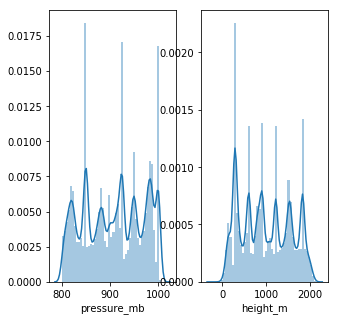

In [11]:
#check the values after cleaning
f, axes = plt.subplots(1,2 , figsize=(5,5))
sns.distplot(df_gso_raob['pressure_mb'].dropna(), ax=axes[0])
sns.distplot(df_gso_raob['height_m'].dropna(), ax=axes[1])

#### Create dataframe with variables for modeling

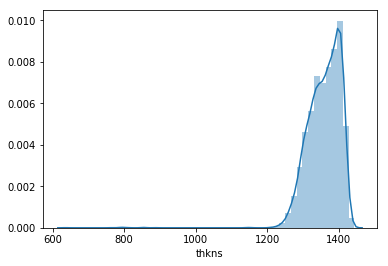

In [12]:
#create empty dataframe
df=pd.DataFrame()

#850 mb height
gso850=df_gso_raob[['validUTC', 'height_m']].loc[(df_gso_raob['pressure_mb']==850)&(df_gso_raob['validUTC'].dt.hour==12)]
gso1000=df_gso_raob[['validUTC', 'height_m']].loc[(df_gso_raob['pressure_mb']==1000)&(df_gso_raob['validUTC'].dt.hour==12)]
df=gso1000.merge(gso850, how='outer', on='validUTC', suffixes=('_1000', '_850'))

#remove rows with na values
df.dropna(inplace=True)

#calculate 1000-850 mb thickness
df['thkns']=df['height_m_850']-df['height_m_1000']

#check thickness distribution
sns.distplot(df['thkns'])

#### Drop thicknesses less than 1200 m, they are not supported by climatology.

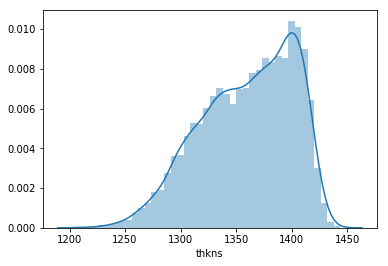

In [13]:
#drop thicknesses less than 1200 m - not supported by climatology
df=df.loc[df['thkns'] >= 1200]

#check thickness distribution
sns.distplot(df['thkns'])

#### Add the dependent variable, minimum temperature, to the dataframe and check the relationship with thickness.

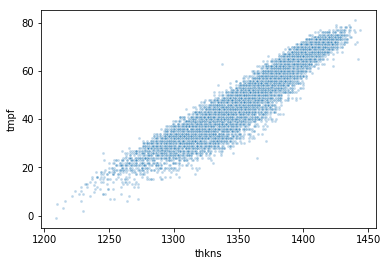

In [14]:
#min temp and sky conditions at the time of mintemp
mintemp=df_gso_metar.loc[df_gso_metar.groupby(df_gso_metar['valid'].dt.date)['tmpf'].idxmin()]

#merge to 1 dataframe
df['valid_date']=df['validUTC'].dt.date
mintemp['valid_date']=mintemp['valid'].dt.date
df=df.merge(mintemp[['valid_date', 'tmpf', 'skyc1', 'mslp']], how='outer', on='valid_date')
#drop missing
df=df.dropna().reset_index()

#plot thickness vs min temp
sns.scatterplot(df.thkns, df.tmpf, alpha=0.3, marker='o', s=8)

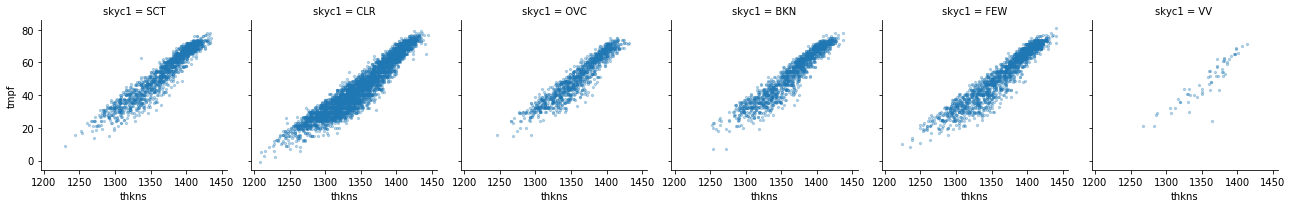

In [15]:
#plot by sky conditions
sky = sns.FacetGrid(df, col="skyc1")
sky.map(plt.scatter,"thkns", "tmpf", alpha=0.3, marker='o', s=5)

### Modeling
Start by using linear regression and neural net. Will compare to other regression options.

#### Create a dataframe to track model performance

In [16]:
#keep track of model performance in a separate data frame
df_model_results=pd.DataFrame(columns=['model', 'data', 'mse', 'mse_std'])

#### Create a naive persistence model for comparison of skill. The previous day's low predicts current day's low.

In [17]:
#naive persistence model
y=df['tmpf'][1:]
y_pred=df['tmpf'].shift(1)[1:]
mse=mean_squared_error(y, y_pred)
print("MSE: ", mse)

#save model results in a dataframe for comparison
df_model_results=df_model_results.append({'model': "naive persistence", 'mse': mse}, ignore_index=True)

MSE:  68.91468159430323


#### Set random seed and assign 10 kfold cross validation

In [18]:
#set random seed
seed=47

#10 kfold cross validation to be used in model validation
kfold = KFold(n_splits=10, random_state=seed)

#### Set up modeling test harness

In [19]:
X=df['thkns'].values.reshape(-1,1)
y=df['tmpf']

In [20]:
#neural net with scaled inputs
def baseline_nn():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=1, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

estimators = []
estimators.append(('minmaxscale', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_nn, epochs=20, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

In [21]:
#test harness for evaluating multiple models
models = []
models.append(('XGB', xgb.XGBRegressor())) 
models.append(('Lasso', Lasso(max_iter=50000))) 
models.append(('LGBM', lgb.LGBMRegressor())) 
models.append(('Ridge', Ridge(alpha=0.01,normalize=True)))
models.append(('NeuralNet',  pipeline))
#models.append(('LR', LinearRegression()))

scoring = 'neg_mean_squared_error'

# evaluate each model 
for name, model in models: 
    results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)     
    mse=-(results.mean())
    mse_std=results.std()
    print(name, mse)
    df_model_results=df_model_results.append({'model': name, 'data': "thkns", 'mse': mse, 'mse_std': mse_std}, ignore_index=True)

XGB 21.632388543833294
Lasso 24.103448933327446
LGBM 21.5802341785566
Ridge 24.121933392536754
NeuralNet 24.242192703796686


In [22]:
#### Find the model with the lowest MSE and plot the actual vs predicted values.

Lowest MSE:  LGBM


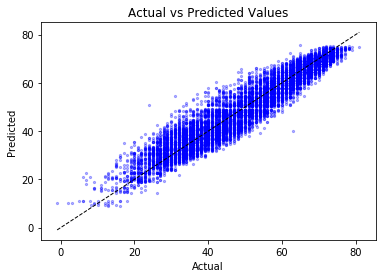

In [23]:
#model with best score
print("Lowest MSE: ", df_model_results['model'].iloc[df_model_results['mse'].idxmin()])
best_name=df_model_results['model'].iloc[df_model_results['mse'].idxmin()]
best_model=[models[x][1] for x in range(0, len(models)) if models[x][0] == df_model_results['model'].iloc[df_model_results['mse'].idxmin()]][0]
predicted=cross_val_predict(best_model, X, y, cv=kfold)

#plot actual vs predicted values    
fig, ax=plt.subplots()
ax.set_title('Actual vs Predicted Values')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=1)
ax.scatter(y, predicted, alpha=0.3, marker='o', s=5, c='b')
plt.show()

#### Add sky conditions (cloud cover) as an indepent variable. Use one hot encoding for the categorical sky conditions. 

In [24]:
#hotcode sky condition
df = pd.concat([df,pd.get_dummies(df['skyc1'], prefix='skyc1')],axis=1)

X=df[['thkns', 'skyc1_BKN', 'skyc1_CLR', 'skyc1_FEW', 'skyc1_OVC', 'skyc1_SCT', 'skyc1_VV ']]
y=df['tmpf']

results = cross_val_score(best_model, X, y, cv=kfold, scoring=scoring)
mse=-(results.mean())
mse_std=results.std()

print(best_name, mse)
df_model_results=df_model_results.append({'model': best_name, 'data': "thkns, skyc1", 'mse': mse, 'mse_std': mse_std}, ignore_index=True)

LGBM 20.522682743301704


#### Add month

In [25]:
df['month'] = df.validUTC.dt.month
df = pd.concat([df,pd.get_dummies(df['month'], prefix='month')],axis=1)
X=df[['thkns', 'skyc1_BKN', 'skyc1_CLR', 'skyc1_FEW', 'skyc1_OVC', 'skyc1_SCT', 'skyc1_VV ', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12']]
y=df['tmpf']

results = cross_val_score(best_model, X, y, cv=kfold, scoring=scoring) 
mse=-(results.mean())
mse_std=results.std()

print(best_name, mse)
df_model_results=df_model_results.append({'model': best_name, 'data': "thkns, skyc1, month", 'mse': mse, 'mse_std': mse_std}, ignore_index=True)

LGBM 15.311273293480582


#### Add mslp

In [26]:
X=df[['thkns', 'skyc1_BKN', 'skyc1_CLR', 'skyc1_FEW', 'skyc1_OVC', 'skyc1_SCT', 'skyc1_VV ', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'mslp']]
y=df['tmpf']

results = cross_val_score(best_model, X, y, cv=kfold, scoring=scoring) 
mse=-(results.mean())
mse_std=results.std()

print(best_name, mse)
df_model_results=df_model_results.append({'model': best_name, 'data': "thkns, skyc1, month, mslp", 'mse': mse, 'mse_std': mse_std}, ignore_index=True)

LGBM 14.693416611139238


#### Add precipitable water 
Precipitable water data was scraped from archived soundings on the University of Wyoming site.
Scraping code is given below as markdown. Data will be loaded as csv next.

Retrieve precipitable water data from archive on the University of Wyoming site  
`df_pw=pd.DataFrame(columns=['dttm', 'pw']) 
pw=[]
dttm=[]
yr = 1990
while yr <= 2020:
  print(yr)
  for mth in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
    print(mth)
    url='http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR='+str(yr)+'&MONTH='+mth+'&FROM=all&TO=3112&STNM=72317'
    response = urllib.request.urlopen(url) 
    webContent = response.read()
    soup = BeautifulSoup(webContent, 'lxml')
    i=1
    while i <  len(soup.find_all('pre')):
       pw.append(soup.find_all('pre')[i].get_text().split('\n')[-2].split(':')[1].lstrip())
       dt=soup.find_all('pre')[i].get_text().split('\n')[3].split(':')[1].split('/')[0].lstrip()
       tm=soup.find_all('pre')[i].get_text().split('\n')[3].split(':')[1].split('/')[1].lstrip()
       dttm.append(pd.to_datetime(dt+tm, format='%y%m%d%H%M'))
       i+=2
  yr+=1
df_pw['dttm']=dttm
df_pw['pw']=pw
df_pw['pw']=pd.to_numeric(df_pw['pw'])
df_pw['dttm']=pd.to_datetime(df_pw['dttm'])`

#### Load csv file

In [27]:
df_pw=pd.read_csv("pw_19900101-2020006.csv", parse_dates=['dttm'])

#### Data validation and cleaning

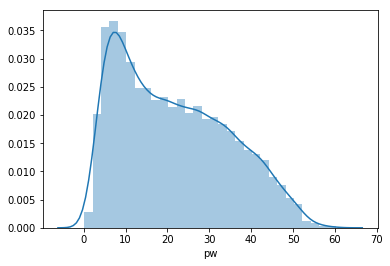

In [28]:
#set negative values to missing
df_pw.loc[df_pw['pw']<=0, 'pw']=np.nan

#join to dataframe
df=df.merge(df_pw, how='outer', left_on='validUTC', right_on='dttm')

#drop missing
df=df.dropna()

#view distribution
sns.distplot(df['pw'])

#### Test all models with final variable set

In [29]:
X=df[['thkns', 'skyc1_BKN', 'skyc1_CLR', 'skyc1_FEW', 'skyc1_OVC', 'skyc1_SCT', 'skyc1_VV ', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'mslp', 'pw']]
y=df['tmpf']



In [30]:
#neural net
def baseline_nn():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
estimators = []
estimators.append(('minmaxscale', MinMaxScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_nn, epochs=20, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

#test harness for evaluating multiple models
models = [] 
models.append(('XGB', xgb.XGBRegressor())) 
models.append(('Lasso', Lasso(max_iter=50000))) 
models.append(('LGBM', lgb.LGBMRegressor())) 
models.append(('Ridge', Ridge(alpha=0.01,normalize=True)))
models.append(('NeuralNet',  pipeline))

# evaluate each model 
for name, model in models: 
    results = cross_val_score(model, X, y, cv=kfold, scoring=scoring) 
    mse=-(results.mean())
    mse_std=results.std()
    print(name, mse)
    df_model_results=df_model_results.append({'model': name, 'data': "thkns, skyc1, month, mslp, pw", 'mse': mse, 'mse_std': mse_std}, ignore_index=True)

XGB 13.862556061072132
Lasso 19.609286404879747
LGBM 12.797711532243309
Ridge 13.725220766106508
NeuralNet 13.694301335283253


### Final model results

In [31]:
print(df_model_results)

                model                           data        mse   mse_std
0   naive persistence                            NaN  68.914682       NaN
1                 XGB                          thkns  21.632389  1.914617
2               Lasso                          thkns  24.103449  1.967296
3                LGBM                          thkns  21.580234  1.974420
4               Ridge                          thkns  24.121933  1.953966
5           NeuralNet                          thkns  24.242193  2.235928
6                LGBM                   thkns, skyc1  20.522683  2.116268
7                LGBM            thkns, skyc1, month  15.311273  1.760546
8                LGBM      thkns, skyc1, month, mslp  14.693417  1.383119
9                 XGB  thkns, skyc1, month, mslp, pw  13.862556  1.258267
10              Lasso  thkns, skyc1, month, mslp, pw  19.609286  1.454601
11               LGBM  thkns, skyc1, month, mslp, pw  12.797712  1.177586
12              Ridge  thkns, skyc1, m

Models show continued improvement with the additional variables. The code could be deployed to give reasonable predictions using NWP model outputs as inputs to improve on raw model forecast miniumum temperatures.